In [1]:
import pandas as pd
import polars as pl
import numpy as np
import lightgbm as lgb

import os
import matplotlib.pyplot as plt

In [2]:
# base_path = '/content/drive/MyDrive/DMEyF/2024/'
base_path = 'C:/Eugenio/Maestria/DMEyF/'
# base_path = '/home/eanegrin/buckets/b1/'

dataset_path = base_path + 'datasets/'
modelos_path = base_path + 'modelos/'
db_path = base_path + 'db/'
dataset_file = 'competencia_02_fe_v01.parquet'

ganancia_acierto = 273000
costo_estimulo = 7000

In [3]:
semillas = [1149, 4836, 9443, 7483, 3492, 6287,  830, 3294, 5932,  815, 7070,
       1529, 3454, 6073, 7831, 1069, 3632,  953,  368, 3999, 9981,  906,
       6792, 1439, 8439, 9240, 8162,   32, 5785, 1013, 2747, 2702, 4807,
       831, 3985, 4003, 4758, 7955, 3976, 5436, 8634, 2511, 8627, 6888,
       4179, 1565, 9181, 6389, 5879, 1216, 8749, 8996,   99, 1481, 4120,
       8561, 7008, 5624,  271, 5204, 9169, 2537, 4070, 5458, 7383,  137,
       8414, 6327, 3119, 5659, 2907, 9390, 7055, 9770, 9614, 6769,  694,
       7854, 9925, 7895, 5259, 9598, 6352, 7884, 5592, 7017, 7374, 2208,
       7364, 1995, 7264, 2520, 3922, 7704, 2333, 1601, 2534, 6556, 9072,
       3046]

In [4]:
data = pl.scan_parquet(dataset_path + dataset_file).filter(pl.col("foto_mes") == 202106).collect()

In [5]:
# convierto a pandas dataframe
data = data.to_pandas()

In [6]:
# Asignamos pesos a las clases

data['clase_peso'] = 1.0

data.loc[data['clase_ternaria'] == 'BAJA+2', 'clase_peso'] = 1.00002
data.loc[data['clase_ternaria'] == 'BAJA+1', 'clase_peso'] = 1.00001

In [7]:
data['clase_binaria'] = 0
data['clase_binaria'] = np.where(data['clase_ternaria'] == 'BAJA+2', 1, 0)

In [8]:
X_test = data.drop(['clase_ternaria', 'clase_peso', 'clase_binaria'], axis=1)
y_test = data['clase_binaria']
w_test = data['clase_peso']

Cargo los modelos pre-entrenados

In [9]:
version = 'v016'

modelos_folder = modelos_path + version

modelos = [f'{modelos_folder}/{modelo}' for modelo in os.listdir(modelos_folder)]

In [9]:
len(modelos)

100

In [12]:
X_test_with_predictions = data.drop(['clase_ternaria', 'clase_peso', 'clase_binaria'], axis=1).copy()

In [13]:
counter = 0

for modelo in modelos[0:10]:
    
    # cargamos el modelo
    model = lgb.Booster(model_file=modelo)
    
    # predecimos para agosto
    X_test = data.drop(['clase_ternaria', 'clase_peso', 'clase_binaria'], axis=1).copy()
    y_pred_lgm = model.predict(X_test)
    X_test_with_predictions[f'pred_lgm_{semillas[counter]}'] = y_pred_lgm
    
    print(f'Predicciones del modelo: {modelo} DONE')
    
    counter += 1

Predicciones del modelo: C:/Eugenio/Maestria/DMEyF/modelos/v016/lgb_competencia2_v016_s1013.txt DONE
Predicciones del modelo: C:/Eugenio/Maestria/DMEyF/modelos/v016/lgb_competencia2_v016_s1013_final.txt DONE
Predicciones del modelo: C:/Eugenio/Maestria/DMEyF/modelos/v016/lgb_competencia2_v016_s1069.txt DONE
Predicciones del modelo: C:/Eugenio/Maestria/DMEyF/modelos/v016/lgb_competencia2_v016_s1069_final.txt DONE
Predicciones del modelo: C:/Eugenio/Maestria/DMEyF/modelos/v016/lgb_competencia2_v016_s1149.txt DONE
Predicciones del modelo: C:/Eugenio/Maestria/DMEyF/modelos/v016/lgb_competencia2_v016_s1149_final.txt DONE
Predicciones del modelo: C:/Eugenio/Maestria/DMEyF/modelos/v016/lgb_competencia2_v016_s1216.txt DONE
Predicciones del modelo: C:/Eugenio/Maestria/DMEyF/modelos/v016/lgb_competencia2_v016_s1216_final.txt DONE
Predicciones del modelo: C:/Eugenio/Maestria/DMEyF/modelos/v016/lgb_competencia2_v016_s137.txt DONE
Predicciones del modelo: C:/Eugenio/Maestria/DMEyF/modelos/v016/lgb_

In [14]:
X_test_with_predictions = X_test_with_predictions.copy()

In [15]:
y_pred_lgm = X_test_with_predictions.iloc[:, -10:].mean(axis=1)

ganancia = np.where(w_test == 1.00002, ganancia_acierto, 0) - np.where(w_test != 1.00002, costo_estimulo, 0)
    
idx = np.argsort(y_pred_lgm)[::-1]
ganancia = ganancia[idx]

ganancia_cum = np.cumsum(ganancia)
ganancia_max = ganancia_cum.max()
ganancia_max

np.int64(150794000)

In [16]:
gan_max_idx = np.where(ganancia_cum == ganancia_max)[0][0]
gan_max_idx

np.int64(12137)

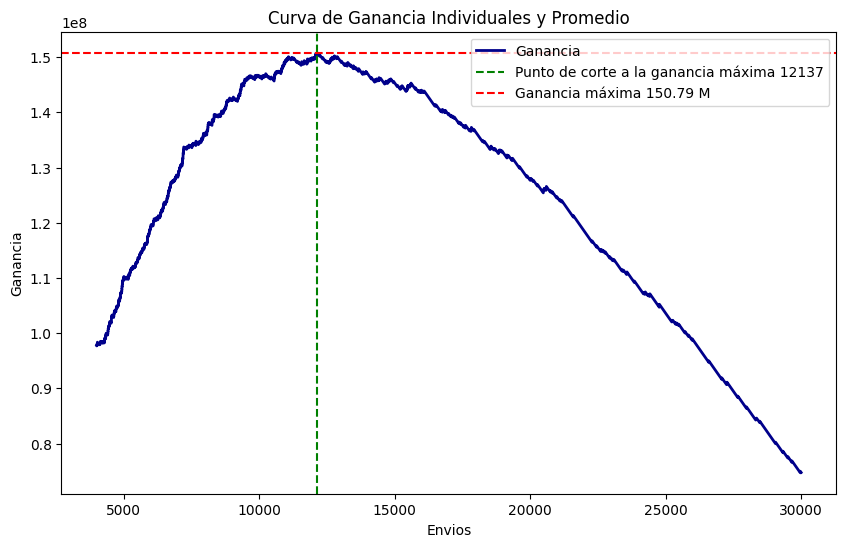

In [17]:
piso_envios = 4000
techo_envios = 30000

plt.figure(figsize=(10, 6))

plt.plot(
    range(piso_envios, len(ganancia_cum[piso_envios:techo_envios]) + piso_envios),
    ganancia_cum[piso_envios:techo_envios],
    color='darkblue',
    linewidth=2,
    label='Ganancia'
)

plt.axvline(
    x=gan_max_idx,
    color='g',
    linestyle='--',
    label=f'Punto de corte a la ganancia máxima {gan_max_idx}'
)

plt.axhline(
    y=ganancia_max,
    color='r',
    linestyle='--',
    label=f'Ganancia máxima {ganancia_max/1000000:.2f} M'
)

plt.title('Curva de Ganancia Individuales y Promedio')
plt.xlabel('Envios')
plt.ylabel('Ganancia')
plt.legend()
plt.show()

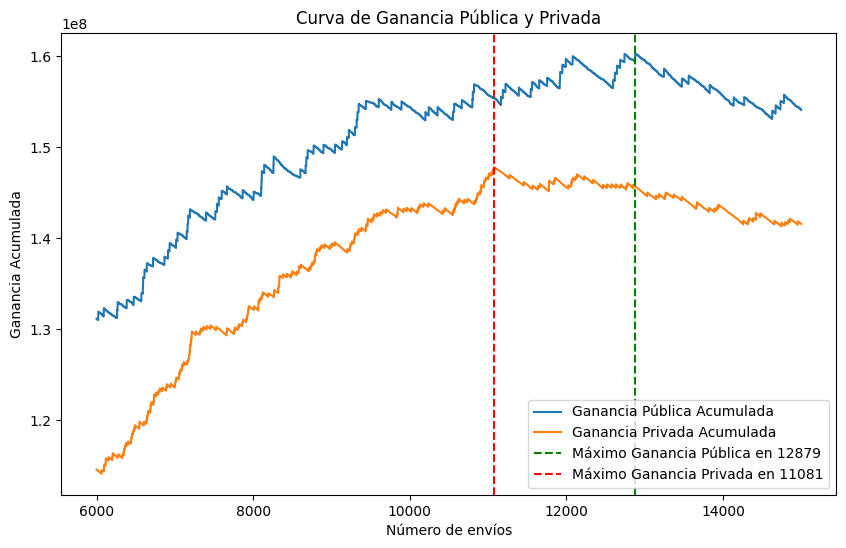

In [35]:
from sklearn.model_selection import train_test_split

df_cut_point = pd.DataFrame({'ganancia': ganancia, 'y_pred_lgm': y_pred_lgm})

private_idx, public_idx = train_test_split(X_test_with_predictions.index, test_size=0.3, random_state=1123425556, stratify=y_test)

df_cut_point['public'] = 0.0
df_cut_point['private'] = 0.0
df_cut_point.loc[private_idx, 'private'] = ganancia[private_idx] / 0.7
df_cut_point.loc[public_idx, 'public'] = ganancia[public_idx] / 0.3

df_cut_point['nro_envios'] = df_cut_point.reset_index().index

df_cut_point['public_cum'] = df_cut_point['public'].cumsum()
df_cut_point['private_cum'] = df_cut_point['private'].cumsum()

plt.figure(figsize=(10, 6))
plt.plot(df_cut_point['nro_envios'][6000:15000], df_cut_point['public_cum'][6000:15000], label='Ganancia Pública Acumulada')
plt.plot(df_cut_point['nro_envios'][6000:15000], df_cut_point['private_cum'][6000:15000], label='Ganancia Privada Acumulada')

max_public_cum = df_cut_point['public_cum'][6000:15000].max()
max_public_idx = df_cut_point['public_cum'][6000:15000].idxmax()
plt.axvline(x=max_public_idx, color='g', linestyle='--', label=f'Máximo Ganancia Pública en {max_public_idx}')

max_private_cum = df_cut_point['private_cum'][6000:15000].max()
max_private_idx = df_cut_point['private_cum'][6000:15000].idxmax()
plt.axvline(x=max_private_idx, color='r', linestyle='--', label=f'Máximo Ganancia Privada en {max_private_idx}')

plt.title('Curva de Ganancia Pública y Privada')
plt.xlabel('Número de envíos')
plt.ylabel('Ganancia Acumulada')
plt.legend()
plt.show()

In [ ]:
def analisis_1(semilla):
  df_cut_point = pd.DataFrame({'ganancia': ganancia, 'y_pred_lgm': y_pred_lgm})

  private_idx, public_idx = train_test_split(X_test_with_predictions.index, test_size=0.3, random_state=semilla, stratify=y_test_binaria1)

  df_cut_point['public'] = 0.0
  df_cut_point['private'] = 0.0
  df_cut_point.loc[private_idx, 'private'] = ganancia[private_idx] / 0.7
  df_cut_point.loc[public_idx, 'public'] = ganancia[public_idx] / 0.3

  df_cut_point['nro_envios'] = df_cut_point.reset_index().index

  df_cut_point['public_cum'] = df_cut_point['public'].cumsum()
  df_cut_point['private_cum'] = df_cut_point['private'].cumsum()

  plt.figure(figsize=(10, 6))
  plt.plot(df_cut_point['nro_envios'][4000:20000], df_cut_point['public_cum'][4000:20000], label='Ganancia Pública Acumulada')
  plt.plot(df_cut_point['nro_envios'][4000:20000], df_cut_point['private_cum'][4000:20000], label='Ganancia Privada Acumulada')

  max_public_cum = df_cut_point['public_cum'][4000:20000].max()
  max_public_idx = df_cut_point['public_cum'][4000:20000].idxmax()
  plt.axvline(x=max_public_idx, color='g', linestyle='--', label=f'Máximo Ganancia Pública en {max_public_idx}')

  max_private_cum = df_cut_point['private_cum'][4000:20000].max()
  max_private_idx = df_cut_point['private_cum'][4000:20000].idxmax()
  plt.axvline(x=max_private_idx, color='r', linestyle='--', label=f'Máximo Ganancia Privada en {max_private_idx}')

  plt.title('Curva de Ganancia Pública y Privada')
  plt.xlabel('Número de envíos')
  plt.ylabel('Ganancia Acumulada')
  plt.legend()
  plt.show()

analisis_1(semillas[1])